# Rosetta Stone

Ce notebook sera porté sur une problématique de traduction englais -> francais.

Il servira aussi à découvrir les réseaux de neuronnes récurrents

## Import

In [1]:
import numpy as np
import pandas as pd

# Python functions

import functions as fonc

# Dataviz

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS 

from PIL import Image 
from mtbpy import mtbpy 
import seaborn as sns

# NLP

import nltk
import string
from nltk.corpus import stopwords
from collections import Counter

from nltk.stem import WordNetLemmatizer 
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Dropout, LSTM, Embedding, Bidirectional
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [2]:
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lowte\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lowte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lowte\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Lowte\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lowte\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Dataviz

### Données pour la dataviz

In [3]:
t_an = pd.read_fwf('src/small_vocab_en.txt', index= None, header=None)
t_fr = pd.read_fwf('src/small_vocab_fr.txt', index= None, header=None)
dic = pd.read_fwf('src/dictionnaire.txt', index= None, header=None)

### Selection des données

In [4]:
corpus = t_an[0]
muscus = t_fr[0]
print(corpus); print(muscus)

0         new jersey is sometimes quiet during autumn , ...
1         the united states is usually chilly during jul...
2         california is usually quiet during march , and...
3         the united states is sometimes mild during jun...
4         your least liked fruit is the grape , but my l...
                                ...                        
137855    france is never busy during march , and it is ...
137856    india is sometimes beautiful during spring , a...
137857    india is never wet during summer , but it is s...
137858    france is never chilly during january , but it...
137859    the orange is her favorite fruit , but the ban...
Name: 0, Length: 137860, dtype: object
0         new jersey est parfois calme pendant l' automn...
1         les Ã©tats-unis est gÃ©nÃ©ralement froid en ju...
2         california est gÃ©nÃ©ralement calme en mars , ...
3         les Ã©tats-unis est parfois lÃ©gÃ¨re en juin ,...
4         votre moins aimÃ© fruit est le raisin , mais m...
 

### Nuage de mots

#### nuage de mot anglais

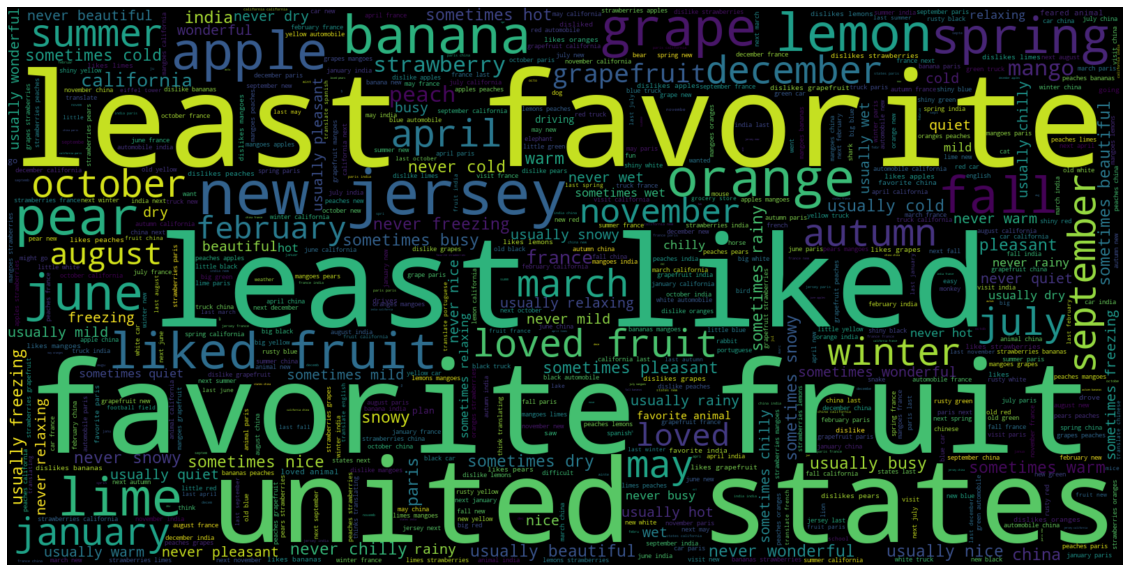

In [5]:
plt.figure(figsize=(20,20))
wc_ang = WordCloud(max_words= 2000, width= 1600, height= 800).generate(" ".join(corpus))#, stopwords= stopword_an
plt.imshow(wc_ang, interpolation= 'bilinear')
plt.axis('off')
plt.show()

On peut observer un vocabulaire tourné sur la description, les mois et les fruits.

#### nuage de mote francais

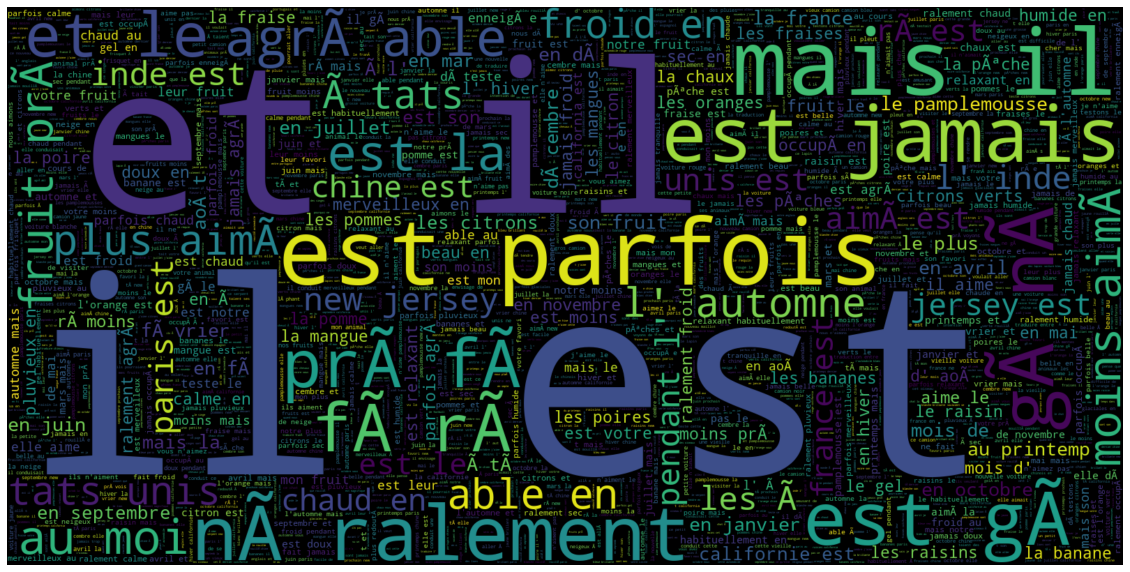

In [6]:
plt.figure(figsize=(20,20))
wc_fr = WordCloud(max_words= 2000, width= 1600, height= 800).generate(" ".join(muscus))
plt.imshow(wc_fr, interpolation= 'bilinear')
plt.axis('off')
plt.show()

Sur ce nuage de point on ne voit pratiquement que des stop words, il va falloir refaire une visualisation une fois les avori enlevé.

### Stop words dataviz

In [7]:
stopwords_ang = nltk.corpus.stopwords.words('english')
stopwords_fr = nltk.corpus.stopwords.words('french')

words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()

### Nuage des mots sans les stop words

#### Nuage de mots anglais

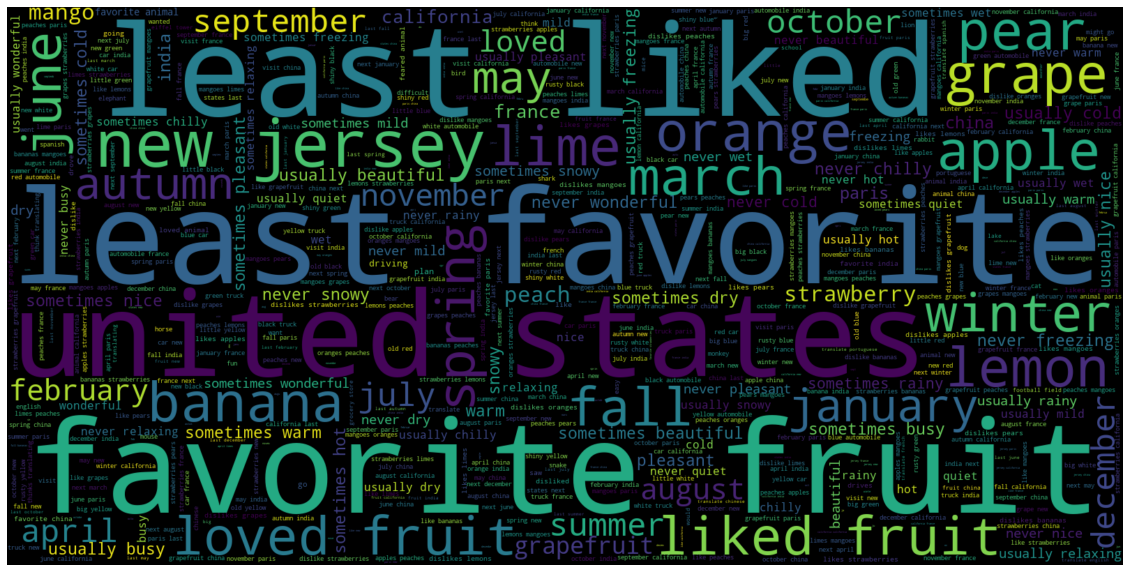

In [8]:
plt.figure(figsize=(20,20))
wc_ang = WordCloud(max_words= 2000, width= 1600, height= 800, stopwords= stopwords_ang).generate(" ".join(corpus))#
plt.imshow(wc_ang, interpolation= 'bilinear')
plt.axis('off')
plt.show()

Une fois les stop words enlevé nous avons toujours les mêmes mots qui sont majoritaires dans nos données

#### Nuage de mots francais

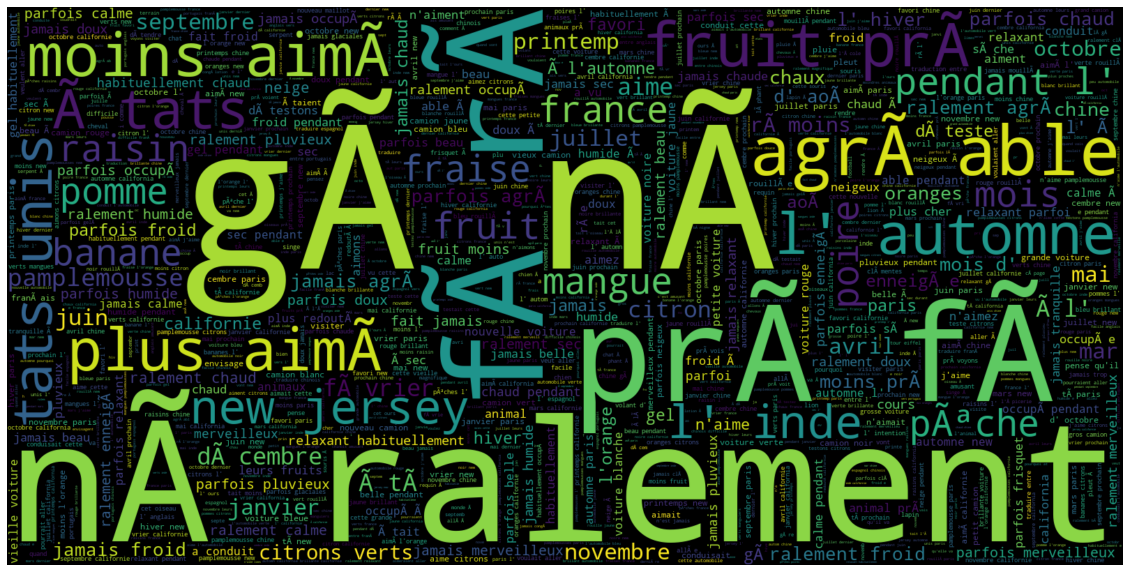

In [9]:
plt.figure(figsize=(20,20))
wc_fr = WordCloud(max_words= 2000, width= 1600, height= 800, stopwords= stopwords_fr).generate(" ".join(muscus))
plt.imshow(wc_fr, interpolation= 'bilinear')

plt.axis('off')
plt.show()

Maintenant que les stop words ont été enlevé nous voyons que le vocabulaire se rapproche beaucoup plus de celui anglais avec une majorité de descritions, fruits et saisons.

### Traitement dataviz : Nettoyage, Tokenisation, Lemmatisation

#### Anglais

In [10]:
def Preprocess_listofSentence_ang(listofSentence):
    preprocess_list = []
    for sentence in listofSentence :
        
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
        
        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())

        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)
        
        words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords_ang]
        
        words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)

        sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in words or not w.isalpha())
        
        preprocess_list.append(sentence_clean)
    
    return preprocess_list

In [11]:
corpus_list = Preprocess_listofSentence_ang(corpus)

#### Français

In [12]:
french_stopwords = nltk.corpus.stopwords.words('french')
mots = set(line.strip() for line in dic[0])
lemmatizer = FrenchLefffLemmatizer()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\french_lefff_lemmatizer/data/lefff-3.4.mlex'

In [ ]:
def French_Preprocess_listofSentence(listofSentence):
    preprocess_list = []
    for sentence in listofSentence :
        
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
        
        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())
 
        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)
        
        words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords_fr]
        
        words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)
 
        sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in mots or not w.isalpha())
        
        preprocess_list.append(sentence_clean)
    
    return preprocess_list

In [ ]:
muscus_list = French_Preprocess_listofSentence(muscus)

#### Visulation d'une phrase avant et apres traitement


In [ ]:
print('Phrase de base : '+corpus[2])
print('Phrase nettoyée : '+corpus_list[2])

In [ ]:
print('Phrase de base : '+muscus[0])
print('Phrase nettoyée : '+muscus_list[0])

#### Calcul de l'occurrence des mots

In [ ]:
eap_text = " ".join(corpus_list)
eap_list = eap_text.split()
eap_counts = Counter(eap_list)
eap_common_words = [word[0] for word in eap_counts.most_common(25)]
eap_common_counts = [word[1] for word in eap_counts.most_common(25)]

In [ ]:
eap_text_fr = ' '.join(muscus_list)
eap_list_fr = eap_text_fr.split()
eap_counts_fr = Counter(eap_list_fr)
eap_common_words_fr = [word[0] for word in eap_counts_fr.most_common(15)]
eap_common_counts_fr = [word[1] for word in eap_counts_fr.most_common(15)]

### Histogramme des 25 mots les plus fréquents

#### Anglais

In [ ]:
sns.set_theme(style="whitegrid")
plt.style.use('dark_background')
plt.figure(figsize=(10, 7))

sns.barplot(y=eap_common_words, x=eap_common_counts)
plt.title('Histogramme des mots en Anglais')
sns.despine(left=True, bottom=True)

#### Francais

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(10, 7))

sns.barplot(y=eap_common_words_fr, x=eap_common_counts_fr)
plt.title('Most Common Words used by Edgar Allen Poe');

### Diagramme circulaire des 25 mots les plus fréquents

#### Anglais

In [ ]:
plt.figure(figsize=(11, 11))
plt.pie(eap_common_counts, labels=eap_common_words)
plt.title('Diagramme circulaire des 25 mots les fréquents Anglais')
sns.despine(left=True, bottom=True)

#### Francais

In [ ]:
plt.figure(figsize=(11, 11))
plt.pie(eap_common_counts_fr, labels=eap_common_words_fr)
plt.title('Diagramme circulaire des 25 mots les fréquents Anglais')
plt.show()

### Nuage de point

#### Anglais

In [ ]:
plt.figure(figsize=(10, 7))
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=False)
ax = sns.scatterplot(y=eap_common_words, x=eap_common_counts,
                    color = 'magenta',
                     sizes=(10, 7),
                      legend="full")# 'blue'

#### Francais

In [ ]:
plt.figure(figsize=(10, 7))
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=False)
ax = sns.scatterplot(y=eap_common_words_fr, x=eap_common_counts_fr,
                     sizes=(10, 7), color = 'magenta',
                      legend="full")

## Creation des models

### Récupération des données

In [13]:
# Load English data
english_sentences = fonc.load_data('src/small_vocab_en.txt')
# Load French data
french_sentences = fonc.load_data('src/small_vocab_fr.txt')

In [14]:
for sample_i in range(5):
    print('English sample {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('French sample {}:  {}\n'.format(sample_i + 1, french_sentences[sample_i]))

English sample 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
French sample 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

English sample 2:  the united states is usually chilly during july , and it is usually freezing in november .
French sample 2:  les Ã©tats-unis est gÃ©nÃ©ralement froid en juillet , et il gÃ¨le habituellement en novembre .

English sample 3:  california is usually quiet during march , and it is usually hot in june .
French sample 3:  california est gÃ©nÃ©ralement calme en mars , et il est gÃ©nÃ©ralement chaud en juin .

English sample 4:  the united states is sometimes mild during june , and it is cold in september .
French sample 4:  les Ã©tats-unis est parfois lÃ©gÃ¨re en juin , et il fait froid en septembre .

English sample 5:  your least liked fruit is the grape , but my least liked is the apple .
French sample 5:  votre moins aimÃ© fruit est le raisin , mais mon moins aimÃ© est la pomme .



### Analyse du nombre de mots

In [15]:
english_words_counter = Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


On peut voir qu'une majorité de mots sont des stop words et de la ponctuation

### Pré-traitement

In [16]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

fonc.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [17]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    return pad_sequences(x, maxlen=length, padding='post')

fonc.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [18]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 345


Une fois nos données traité il va nous faloir une fonction pour repasser les indexs de notre dictionnaire en mots

In [19]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = ''

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Création des modèles

#### Modèle 1

Entrainement d'un modèle avec seulement un GRU

In [23]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

print(simple_rnn_model.summary())

history = simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 21, 256)           198912    
                                                                 
 time_distributed_2 (TimeDis  (None, 21, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 21, 1024)          0         
                                                                 
 time_distributed_3 (TimeDis  (None, 21, 346)          354650    
 tributed)                                                       
                                                                 
Total params: 816,730
Trainable params: 816,730
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
108/108 [=======================

In [35]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print("\nOriginal text:")
print(english_sentences[:1])

Prediction:
1/1 [==============================] - 0s 21ms/step
new jersey est parfois chaud en mois de il et il est en en       

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


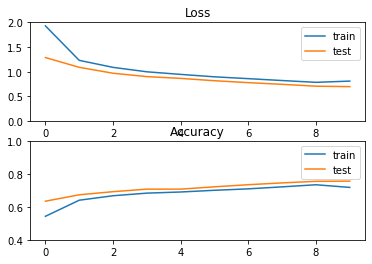

In [34]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim([0,2])
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylim([0.4,1])
plt.legend()
plt.show()

Ce model a une accuracy de 73% ce qui ne sera pas suffisant pour la traduction

#### Modèle 2

Ajout d'un word embeding

In [36]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(256, return_sequences=True))    
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# TODO: Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

embed_rnn_model.summary()

history = embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# TODO: Print prediction(s)
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 256)           51200     
                                                                 
 gru_2 (GRU)                 (None, 21, 256)           394752    
                                                                 
 time_distributed_4 (TimeDis  (None, 21, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_2 (Dropout)         (None, 21, 1024)          0         
                                                                 
 time_distributed_5 (TimeDis  (None, 21, 346)          354650    
 tributed)                                                       
                                                                 
Total params: 1,063,770
Trainable params: 1,063,770
No

In [37]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print("\nOriginal text:")
print(english_sentences[:1])

Prediction:
1/1 [==============================] - 0s 21ms/step
new jersey est parfois calme en l' automne et il est neigeux en avril       

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


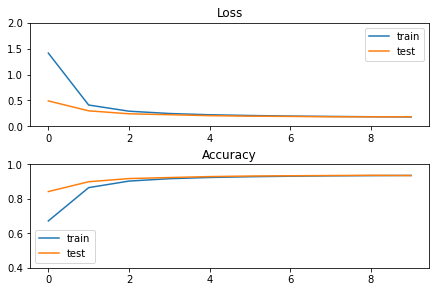

In [42]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim([0,2])
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylim([0.4,1])
plt.legend()
plt.tight_layout(pad=0.5)
plt.show()

Avec de l'embeding on peut voir que le model arrive à de meilleurs résultat et nous avons pratiquement la traduction complète.

#### Modèle 3

test sans word embeding mais avec un modèle bidirectionnel

In [43]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.003
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape[1:]))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# TODO: Train and Print prediction(s)
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

embed_rnn_model.summary()

history = embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21, 256)           51200     
                                                                 
 gru_3 (GRU)                 (None, 21, 256)           394752    
                                                                 
 time_distributed_6 (TimeDis  (None, 21, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 21, 1024)          0         
                                                                 
 time_distributed_7 (TimeDis  (None, 21, 346)          354650    
 tributed)                                                       
                                                                 
Total params: 1,063,770
Trainable params: 1,063,770
No

In [44]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print("\nOriginal text:")
print(english_sentences[:1])

Prediction:
1/1 [==============================] - 0s 18ms/step
new jersey est parfois calme en l' automne et il est neigeux en avril       

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


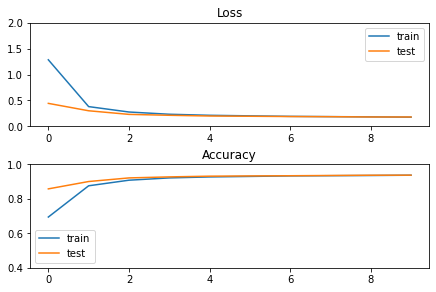

In [45]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim([0,2])
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylim([0.4,1])
plt.legend()
plt.tight_layout(pad=0.5)
plt.show()

Le model bidirectionnel atteint les mêmes performances que le modèle avec le word embeding, nous allons maintenant essayé de combiné les deux pour voir si l'on peut encore pousser les performances plus loin

#### Modèle 4

Word embeding + bidirectionnel + seq2seq

In [46]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.003
    
    # Build the layers    
    model = Sequential()
    # Embedding
    model.add(Embedding(english_vocab_size, 128, input_length=input_shape[1],
                         input_shape=input_shape[1:]))
    # Encoder
    model.add(Bidirectional(GRU(128)))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


print('Final Model Loaded')

Final Model Loaded


In [48]:
# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# TODO: Train and Print prediction(s)
final_model = model_final(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

final_model.summary()

history = final_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=25, validation_split=0.2)

print(logits_to_text(final_model.predict(tmp_x[:1])[0], french_tokenizer))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 21, 128)           25600     
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 repeat_vector_1 (RepeatVect  (None, 21, 256)          0         
 or)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 21, 256)          296448    
 nal)                                                            
                                                                 
 time_distributed_10 (TimeDi  (None, 21, 512)          131584    
 stributed)                                           

In [49]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(final_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print("\nOriginal text:")
print(english_sentences[:1])

Prediction:
1/1 [==============================] - 0s 22ms/step
new jersey est parfois calme pendant l' automne et il est neigeux en avril       

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


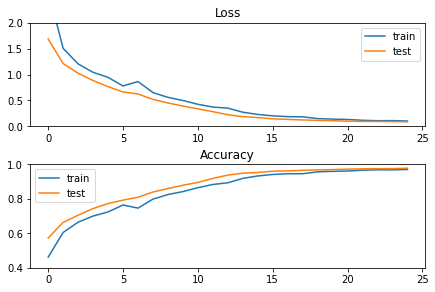

In [50]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim([0,2])
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylim([0.4,1])
plt.legend()
plt.tight_layout(pad=0.5)
plt.show()

Ce dernier modèle fini avec un accuracy de 97%, on peut néamoins voir que le seq2seq a ralenti l'apprentissage du modèle.